In [1]:
# loading useful packages
import pandas as pd
import seaborn as sns

### Slovník pojmů:

product_by_counts - tabulka zobrazuje top 3 produktů s nejlepším poměrem kliků ku zobrazení\
click_rate - sloupes v tabulce product_by_counts s výpočtem klik/zobrazení\
category_by_counts - tabulka suma zobrazení a kliků podle produktů\
correlation - vypočet koeficientu závislosti počtů prokliků na nabídce produktů\
availability_by_counts - počet prokliků v kategorii produktů s důrazem na dostupnost 

In [2]:
 #read the file
click = pd.read_csv('click.csv', sep = ';', names = ['userId', 'clickTime', 'productId', 'availability', 'pos', 'clickCount'])
impress = pd.read_csv ('impress.csv', sep = ';', names =  ['userId', 'impressTime', 'productId', 'categoryName', 'offers', 'impressCount'])

In [3]:
#preprocessing steps
click['userId'] = click['userId'].abs()
click = click[~click['productId'].isin(['\\N'])]
impress['userId'] = impress['userId'].abs()
impress = impress[~impress['productId'].isin(['\\N'])]

click[['userId','productId','clickCount']] = click[['userId','productId','clickCount']].astype('int64') 
impress[['userId','productId','impressCount','offers']] = impress[['userId','productId','impressCount','offers']].astype('int64')

In [4]:
# join tables based on userId, productId columns
# vysledna tabulka
df = impress.merge(click, how = 'left', on = ['userId', 'productId']).fillna(0)
df.head()

,userId,impressTime,productId,categoryName,offers,impressCount,clickTime,availability,pos,clickCount
0,1000667737595868520,16:53:28,5345155,Outdoorové batohy,18,1,0,0,0,0.0
1,1000986301389262527,16:11:23,929457,Letní osobní pneu,66,1,0,0,0,0.0
2,1001489680877270341,15:36:57,5841880,Chytré hodinky,107,1,0,0,0,0.0
3,1004940724779872737,15:04:13,4065922,Kanalizační potrubí,2,1,15:04:22,at_depot,0,1.0
4,100703232129898231,15:29:23,488638,Homeopatika,39,1,0,0,0,0.0


### U jakého produktu je nejlepší poměr prokliků ku zobrazení?

In [5]:
#tabulka celková suma impressCount a clickCount podle každého productId
#výběr jen nenulových řádků v clickCount
#výpočet poměru prokliků ku zobrazení
#zobrazení top 3 nejlepších hodnot poměrů kliknutí ku zobrazení 
product_by_counts = df[['productId','impressCount','clickCount']].groupby('productId').sum()
product_by_counts = product_by_counts[product_by_counts.clickCount != 0]
product_by_counts['click_rate']=product_by_counts.apply(lambda row: row.clickCount / row.impressCount, axis=1)

product_by_counts.sort_values('click_rate', ascending = False).head(3)

,impressCount,clickCount,click_rate
productId,,,
5018434,1,2.0,2.0
6382055,4,8.0,2.0
6348589,1,2.0,2.0


### Která produktová kategorie je nejproklikávanější a která nejzobrazovanější?

In [6]:
#tabulka celková suma zobrazení a prokliků podle kategorie produktu
category_by_counts = df[['categoryName','impressCount','clickCount']].groupby('categoryName',as_index=False).sum()

impressMaxCategory = category_by_counts.sort_values('impressCount', ascending=False).head(1).iat[0,0]
impressMaxCount = category_by_counts.sort_values('impressCount', ascending=False).head(1).iat[0,1]
clickMaxCategory = category_by_counts.sort_values('clickCount', ascending=False).head(1).iat[0,0]
clickMaxCount = category_by_counts.sort_values('clickCount', ascending=False).head(1).iat[0,2]

In [7]:
print(f'Největší počet zobrazení je v kategorii {impressMaxCategory}, počet zobrazení: {impressMaxCount} \nNejvětší počet prokliků je v kategorii {clickMaxCategory}, počet prokliků: {clickMaxCount}')

Největší počet zobrazení je v kategorii Ochranné masky, roušky a respirátory, počet zobrazení: 2623 
Největší počet prokliků je v kategorii Ochranné masky, roušky a respirátory, počet prokliků: 1902.0


### Má počet nabídek produktu nějaký vliv na jeho proklikovost?

In [8]:
#výpočet a zobrazéní korelace mezí počtem nabídek produktů a počtů kliků
correlation = df['offers'].corr(df['clickCount'])
print(f'Korelační koeficient se rovná {correlation}, což ukazuje na to, že mezi počtem nabídek zobrazeného produktu a počtem kliku není lineární závoslot')

Korelační koeficient se rovná 0.052060271580508174, což ukazuje na to, že mezi počtem nabídek zobrazeného produktu a počtem kliku není lineární závoslot


Zobrazíme body na grafu a pokusíme se zjístit, zda existuje jiný druh závislosti


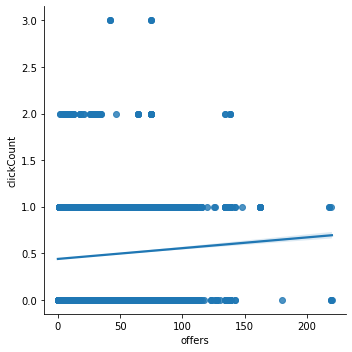

In [9]:
print('Zobrazíme body na grafu a pokusíme se zjístit, zda existuje jiný druh závislosti')
g = sns.lmplot(x = 'offers', y = 'clickCount', data = df[['offers','clickCount']])

Na základě koeficientu a grafu můžeme říct že žádná korepace mezí počtem nabídek produktů a jeho proklikovosti není

### Pro zajimavost se podivám počet prokliků v kategorii produktů, jak se v každé kategorie rozlišuje na základě dostupnosti

In [10]:
#výběr dat pro tabulku
availability_by_counts = df[['availability','clickCount','categoryName']]

In [11]:
#smazání řádků s nůlovou kategorii
availability_by_counts = availability_by_counts[availability_by_counts['categoryName'] != 0]

In [12]:
#grupování podle canegory produktů a dostupnosti
availability_by_counts.groupby(['categoryName','availability']).sum()

clickCount
categoryName availability                    
3D brýle     0                            0.0
             at_depot                     2.0
3D puzzle    0                            0.0
3D tiskárny  0                            0.0
4x4 pneu     0                            0.0
...                                       ...
Žárovky      at_depot                    29.0
             in_three_days                3.0
             in_week                      5.0
             unknown_availability         2.0
Žíněnky      0                            0.0

[4275 rows x 1 columns]

### KOntrola unikatních kombinaci userID + productId

In [13]:
click_errors = click[['userId','productId']]
impress_errors = impress[['userId','productId']]

In [14]:
result = pd.concat([click_errors,impress_errors],ignore_index=True).drop_duplicates()
result

,userId,productId
0,1004940724779872737,4065922
1,1009998163369194601,6101440
2,1014100200802569040,5862917
4,1015558666283832248,521666
6,1020440695658685824,5008657
...,...,...
57555,999171352273549046,6283899
57556,999683602709492851,5009974
57557,999683602709492851,6345332
57558,999683602709492851,5004718


In [15]:
print(f'Počet unikatních: \n{result.count()}, \nproto možná propojení dat na úrovni konkrétního produktu zobrazeného a prokliknutého jedním uživatelem, a to pomocí atributů userId a productId ukazuje tak divné výsledky')

Počet unikatních: 
userId       33285
productId    33285
dtype: int64, 
proto možná propojení dat na úrovni konkrétního produktu zobrazeného a prokliknutého jedním uživatelem, a to pomocí atributů userId a productId ukazuje tak divné výsledky
